In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [4]:
def happiness(R=1, A=0.5, f=6, N=10, T_steps=500, dt=0.1, k=2):
    
    '''
    R: radius
    A: amplitude
    f: freq
    N: num drones
    T_steps: time steps
    dt: inc in time
    k: gain
    
    '''
    #init
    theta_init = 2 * np.pi * np.arange(N) / N
    r_init = R + A * np.sin(f * theta_init)
    x_init = r_init * np.cos(theta_init)
    y_init = r_init * np.sin(theta_init)


    p = np.stack([x_init, y_init], axis=1)

    drone_positions = [p.copy()]
    targets = []
    
    time = 0

    #changes
    for step in range(T_steps - 1):
        time += dt
        
        theta_target = np.arctan2(np.sin(time + theta_init), np.cos(time + theta_init))
        r_target = R + A * np.sin(f * theta_target)
        x_target = r_target * np.cos(theta_target)
        y_target = r_target * np.sin(theta_target)
        p_target = np.stack([x_target, y_target], axis=1)
        targets.append(p_target.copy())

        velocity = p_target - p
        p = p + k * velocity * dt
        
        drone_positions.append(p.copy())
        
    return np.array(drone_positions), np.array(targets)

In [5]:
def surprise(r_min=0.2, r_max=1, N=10, T_steps=500, dt=0.05, k=1):

    #init
    theta_init = 2 * np.pi * np.arange(N) / N
    
    r0 = r_min
    x_init = r0 * np.cos(theta_init)
    y_init = r0 * np.sin(theta_init)
    p = np.stack([x_init, y_init], axis=1)
    
    drone_positions = [p.copy()]
    targets = []
    
    time = 0

    for step in range(T_steps - 1):
        time += dt

        theta_t = np.arctan2(np.sin(time + theta_init), np.cos(time + theta_init))
        
        r_t = np.mod(time, r_max - r_min) + r_min
        x_target = r_t * np.cos(theta_t)
        y_target = r_t * np.sin(theta_t)
        p_target = np.stack([x_target, y_target], axis=1)
        targets.append(p_target.copy())

        velocity = p_target - p
        p = p + k * velocity * dt
        
        drone_positions.append(p.copy())

    return np.array(drone_positions), np.array(targets)

In [7]:
def sadness(R=0.5, N=10, T_steps=500, dt=0.05, k=1):
    """
    
    """
    # init
    theta_init = 2 * np.pi * np.arange(N) / N

    x_init = R * np.cos(theta_init)
    y_init = R * np.sin(theta_init)
    p = np.stack([x_init, y_init], axis=1)

    drone_positions = [p.copy()]
    targets = []

    time = 0
    for step in range(T_steps - 1):
        time += dt

        theta_t = np.arctan2(np.sin(time + theta_init), np.cos(time + theta_init))

        x_target = R * np.cos(theta_t)
        y_target = R * np.sin(theta_t)
        p_target = np.stack([x_target, y_target], axis=1)
        targets.append(p_target.copy())

        velocity = p_target - p
        p = p + k * velocity * dt

        drone_positions.append(p.copy())

    return np.array(drone_positions), np.array(targets)

In [10]:
rng = np.random.default_rng(0)
x_min, x_max, y_min, y_max = (-1.0, 1.0, -1.0, 1.0)
N = 10
# Initial positions with somewhat deformed circle
angles = rng.uniform(0, 2*np.pi, size=10)
radii  = 0.7 + 0.25*rng.uniform(-1, 1, size=10)
p = np.stack([radii*np.cos(angles), radii*np.sin(angles)], axis=1)

# Prebuild sampling grid over D
xs = np.linspace(x_min, x_max, 90)
ys = np.linspace(y_min, y_max, 90)
X, Y = np.meshgrid(xs, ys)

#flatten
grid_points = np.stack([X.ravel(), Y.ravel()], axis=1)
phi_vals = phi_anger(grid_points[:, 0], grid_points[:, 1])


for t in range(3):
    dists2 = ((grid_points[:, None, :] - p[None, :, :])**2).sum(axis=2)  # [P,N]
    owners = np.argmin(dists2, axis=1)
    # owners = np.argmin(dists2, axis=1)  # [P]
    c = np.zeros_like(p)
    for i in range(N):
        mask = (owners == i)
        if np.any(mask):
            w = phi_vals[mask]                               # [Pi]
            pts = grid_points[mask]                          # [Pi,2]
            W = w.sum()
            if W > 0:
                c[i] = (pts * w[:, None]).sum(axis=0) / W
            else:
                c[i] = p[i].copy()
        else:
            # Empty cell: keep current point (or nudge slightly)
            c[i] = p[i].copy()

phi_vals


array([0.15      , 0.15      , 0.15      , ..., 0.15355714, 0.15260395,
       0.15187439])

In [ ]:
def coverage(density_function, N=10, T_steps=300, domain=(-1.0, 1.0, -1.0, 1.0),
                      grid_res=100, k=2.5, dt=0.05, seed=0):
    
    """ 
    density_function: The density function used. Contributes to computing weighted centroid
    N: num drones
    domain: 2D rectangular space
    grid_res: sampling rate for map
    k: proportional gain
    dt: time step
    seed: for randomized init drone positions
    """
    rng = np.random.default_rng(seed)
    x_min, x_max, y_min, y_max = domain

    # Initial positions with somewhat deformed circle
    angles = rng.uniform(0, 2*np.pi, size=N)
    radii  = 0.7 + 0.25*rng.uniform(-1, 1, size=N)
    p = np.stack([radii*np.cos(angles), radii*np.sin(angles)], axis=1)

    # Prebuild sampling grid over D
    xs = np.linspace(x_min, x_max, grid_res)
    ys = np.linspace(y_min, y_max, grid_res)
    X, Y = np.meshgrid(xs, ys)

    #flatten
    grid_points = np.stack([X.ravel(), Y.ravel()], axis=1)      # [P,2]

    #use a density function to get the value of importance
    density = density_function(grid_points[:, 0], grid_points[:, 1])     # [P]
    # no divide by 0
    density = np.maximum(density, 1e-12)

    simulated_path = np.zeros((T_steps, N, 2), dtype=float)
    target_path    = np.zeros((T_steps, N, 2), dtype=float)

    for t in range(T_steps):
        # For each grid point, find nearest drone index
        dists2 = ((grid_points[:, None, :] - p[None, :, :])**2).sum(axis=2)  # [P,N] find distance 2 each drone using squared differnece
        owners = np.argmin(dists2, axis=1)  # [P] indices of closest drone to each sample point

        #weighted centroid
        centroid = np.zeros_like(p)     # the centroid shifts slightly as drones moves
        for drone in range(N):
            zone = (owners == drone)    #for each drone, find list of points that belongs to it 
            if np.any(zone):
                weights = density[zone]       # [Pi], weights/density of all the sampled points in zone
                pts = grid_points[zone]             # [Pi,2], all coordinates of the region
                W = weights.sum()
                if W > 0:
                    centroid[drone] = (pts * weights[:, None]).sum(axis=0) / W  #compute weighted centroid of the zone for drone k that it will move to
                else:
                    centroid[drone] = p[drone].copy()
            else:
                # Empty cell: keep current point
                centroid[drone] = p[drone].copy()

        #move toward centroid
        p = p + dt * k * (centroid - p)

        simulated_path[t] = p
        target_path[t]    = centroid

    return simulated_path, target_path

In [ ]:
coverage(phi_anger, N=N_DRONE, T_steps=300)

NameError: name 'simulate_coverage' is not defined

In [2]:
def phi_anger(x, y):
    g1 = np.exp(-((x - 0.55)**2 + (y - 0.55)**2) / 0.06)
    g2 = np.exp(-((x - 0.35)**2 + (y - 0.35)**2) / 0.06)
    return 0.15 + 1.6*(g1 + 0.8*g2)

Saving animation as GIF... This may take a moment.


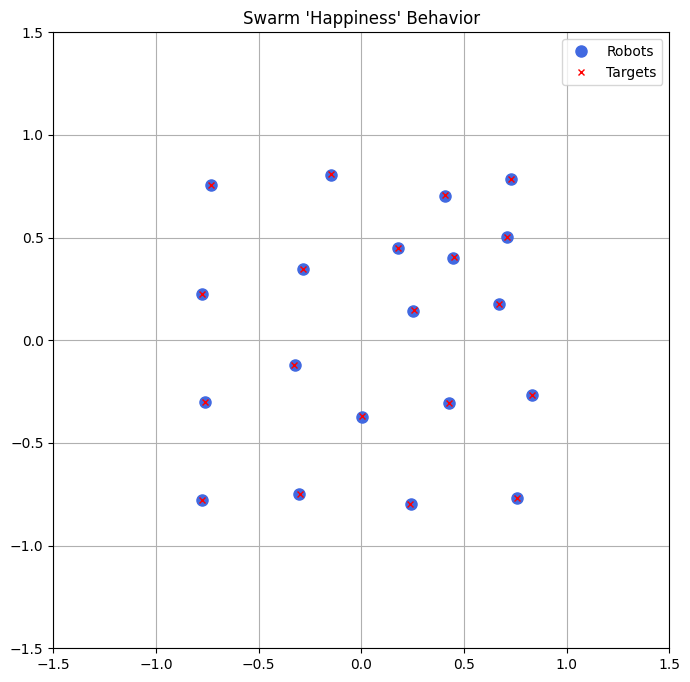

In [ ]:
#animation

N_DRONE = 20


# simulated_path, target_path = happiness(N=N_DRONE, T_steps=300)

# simulated_path, target_path = surprise(N=N_DRONE, T_steps=300)

# simulated_path, target_path = sadness(N=N_DRONE, T_steps=300)

simulated_path, target_path = coverage(phi_anger, N=N_DRONE, T_steps=300)


fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_title("Swarm Behavior")
ax.grid(True)

robots, = ax.plot([], [], 'o', color='royalblue', markersize=8, label="Robots")
targets, = ax.plot([], [], 'x', color='red', markersize=5, label="Targets")
ax.legend()

def update(frame):
    robots.set_data(simulated_path[frame, :, 0], simulated_path[frame, :, 1])
    targets.set_data(target_path[frame, :, 0], target_path[frame, :, 1])
    return robots, targets

ani = FuncAnimation(fig, update, frames=len(target_path), interval=200, blit=True)

print("Saving animation as GIF... This may take a moment.")
ani.save('visuals/swarm_animation.gif', writer='pillow', fps=8)